In [2]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.decomposition import TruncatedSVD

from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding
from openTSNE.affinity import Affinities

import time
import pickle

import memory_profiler
%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [3]:
variables_path = Path('../results/variables')
figures_path = Path('../results/figures')
berenslab_data_path = Path('/gpfs01/berens/data/data/pubmed_processed')

In [5]:
plt.style.use("matplotlib_style.txt")

Pipeline from PubMedBERT embeddings to two dimensional embedding

# Import data

In [5]:
%%time
%%memit
embeddings_reparsed_all=np.load(berenslab_data_path / 'embeddings/embeddings_reparsed_all.npy')

tcmalloc: large alloc 127101853696 bytes == 0x453c000 @ 


peak memory: 121677.40 MiB, increment: 121333.26 MiB
CPU times: user 161 ms, sys: 1min, total: 1min
Wall time: 1min 43s


# t-SNE

Annealing exgg=1, n_iter=2000 

## Affinities

In [6]:
%%capture cap
%%time
A = affinity.Uniform(embeddings_reparsed_all, k_neighbors=10, n_jobs=-1, verbose=1, random_state=42)

tcmalloc: large alloc 1474551808 bytes == 0x1da3c74000 @ 
tcmalloc: large alloc 1916911616 bytes == 0x1dfbab2000 @ 
tcmalloc: large alloc 2491990016 bytes == 0x1e6dece000 @ 
tcmalloc: large alloc 3239583744 bytes == 0x1da3c74000 @ 
tcmalloc: large alloc 4211466240 bytes == 0x1e64df6000 @ 
tcmalloc: large alloc 5474902016 bytes == 0x2048350000 @ 
tcmalloc: large alloc 7117381632 bytes == 0x1da3c74000 @ 
tcmalloc: large alloc 9252593664 bytes == 0x218f096000 @ 
tcmalloc: large alloc 12028370944 bytes == 0x23b708c000 @ 
tcmalloc: large alloc 15636889600 bytes == 0x26847b2000 @ 
tcmalloc: large alloc 20327956480 bytes == 0x2a29832000 @ 
tcmalloc: large alloc 26426335232 bytes == 0x2ee6272000 @ 
tcmalloc: large alloc 34354241536 bytes == 0x350ec90000 @ 
tcmalloc: large alloc 44660514816 bytes == 0x3d10752000 @ 
tcmalloc: large alloc 58058670080 bytes == 0x4778ee8000 @ 
tcmalloc: large alloc 75476271104 bytes == 0x5500ff8000 @ 
tcmalloc: large alloc 98119155712 bytes == 0x66983c0000 @ 


In [7]:
with open( variables_path / 'verbose_tsne_affinities_reparsed.txt', 'w') as f:
    f.write(cap.stdout)

In [1]:
#save results
sp.sparse.save_npz( variables_path / "affinities_P_bert_reparsed", A.P)

In [2]:
# load affinities P
affinities_P_bert_reparsed = sp.sparse.load_npz( variables_path / "affinities_P_bert_reparsed.npz")

tcmalloc: large alloc 2938535936 bytes == 0x477e000 @ 
tcmalloc: large alloc 1469267968 bytes == 0xb3daa000 @ 


In [3]:
# create the affinities object

A = Affinities()
A.P = affinities_P_bert_reparsed

In [4]:
A.P

<20687150x20687150 sparse matrix of type '<class 'numpy.float64'>'
	with 367316980 stored elements in Compressed Sparse Row format>

## Initialization

In [13]:
%%time
%%memit

I = initialization.pca(embeddings_reparsed_all, random_state=42)

np.save( variables_path / "initialization_bert_reparsed", I)

tcmalloc: large alloc 127101853696 bytes == 0x1eeaf1a000 @ 
tcmalloc: large alloc 1985970176 bytes == 0x3c8a4e0000 @ 
tcmalloc: large alloc 1985970176 bytes == 0x3d00ad8000 @ 
tcmalloc: large alloc 127101853696 bytes == 0x3dedec8000 @ 


peak memory: 372337.48 MiB, increment: 245483.95 MiB
CPU times: user 2h 6min 46s, sys: 41min 7s, total: 2h 47min 53s
Wall time: 8min 52s


In [5]:
I=np.load( variables_path / "initialization_bert_reparsed.npy")

## Optimization

In [6]:
Zs = []
kls = []
n_iter = []

def mycallback(iteration, error, embedding):
    Zs.append(embedding.copy())
    kls.append(error)
    n_iter.append(iteration)

In [ ]:
%%capture cap
%%time

E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

# early exaggeration
E = E.optimize(n_iter=125, exaggeration=12, momentum=0.5, n_jobs=-1, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

# exaggeration annealing
exs = np.linspace(12,1,125)
for i in range(125):
    if (i+1)%50 == 0:
        E = E.optimize(n_iter=1, exaggeration=exs[i], momentum=0.8, n_jobs=-1, verbose=True, callbacks=mycallback, callbacks_every_iters=1)
        
    else:
        E = E.optimize(n_iter=1, exaggeration=exs[i], momentum=0.8, n_jobs=-1, verbose=True)
    
# final optimization without exaggeration
E = E.optimize(n_iter=2000, exaggeration=1, momentum=0.8, n_jobs=-1, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

In [ ]:
with open( variables_path / 'verbose_tsne_reparsed.txt', 'w') as f:
    f.write(cap.stdout)

In [ ]:
Zs_array=[]
for i in np.arange(len(Zs)):
    Zs_array.append(np.array(Zs[i]))

In [ ]:
#save results
f = open( variables_path / "Zs_array_reparsed.pkl","wb")
pickle.dump(Zs_array,f)
f.close()

In [ ]:
# #load
# pickle_in = open( variables_path / "Zs_array_reparsed.pkl","rb")
# Zs_array = pickle.load(pickle_in)

In [ ]:
#save iter
f = open( variables_path / "iterations_reparsed.pkl","wb")
pickle.dump(n_iter,f)
f.close()

In [ ]:
# #load
# pickle_in = open( variables_path / "iterations_reparsed.pkl","rb")
# iterations = pickle.load(pickle_in)

In [ ]:
#save kl divergence
f = open( variables_path / "kl_divergence_reparsed.pkl","wb")
pickle.dump(kls,f)
f.close()

In [ ]:
# #load
# pickle_in = open( variables_path / "kl_divergence_reparsed.pkl","rb")
# kls = pickle.load(pickle_in)

In [ ]:
tsne=np.array(E)

#save
np.save( variables_path / "tsne_reparsed", tsne)

In [ ]:
#tsne_reparsed=np.load( variables_path / "tsne_reparsed.npy")

# Plot

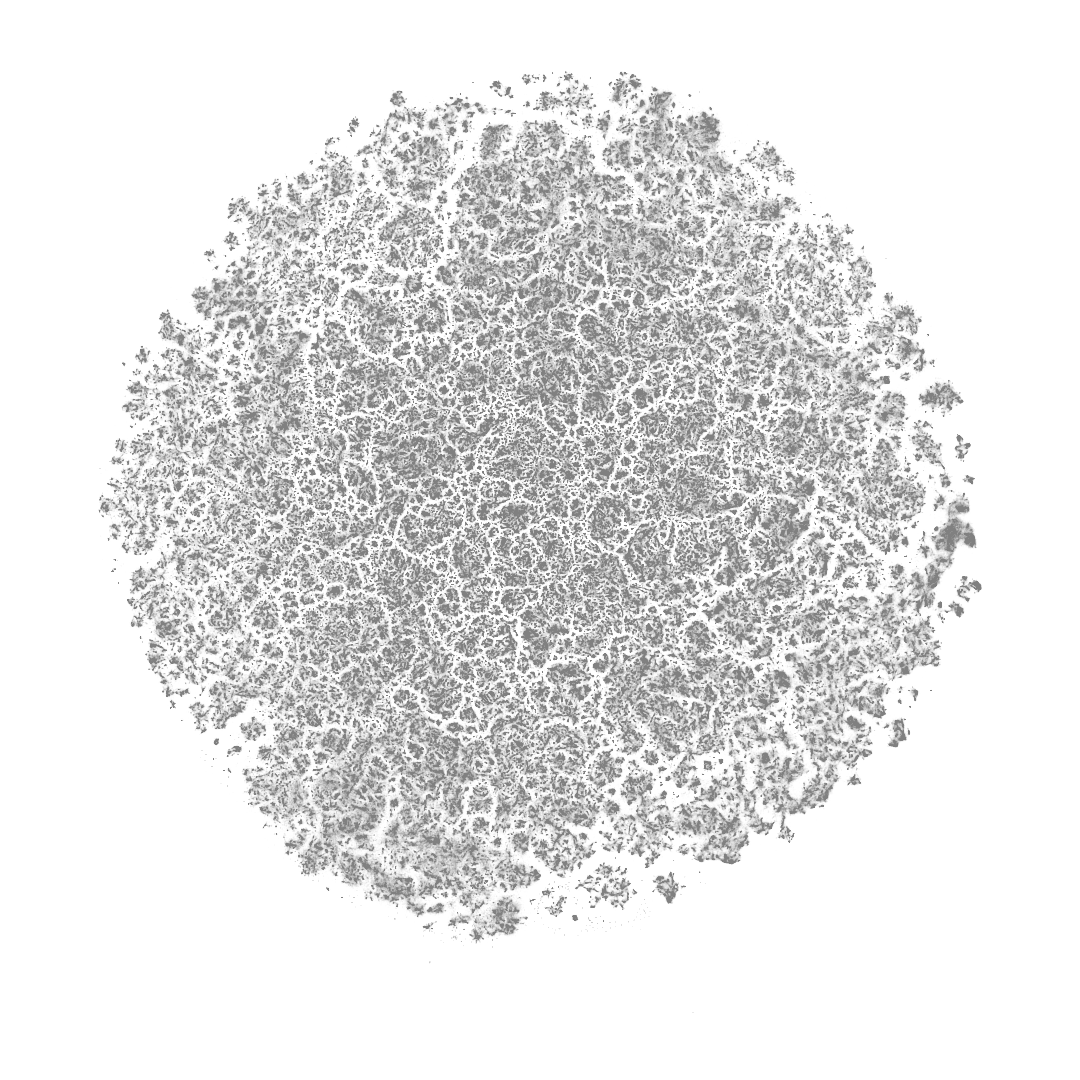

In [20]:
#Plot 
%matplotlib inline 
tsne=tsne
fig1=plt.figure(figsize=(5.5, 5.5),dpi=200)
plt.scatter(tsne[:,0],tsne[:,1],s=0.5,c='grey',marker='.',linewidths=None,ec='None', alpha=0.01, rasterized=True)
plt.axis('equal')
plt.grid()
plt.xticks([])
plt.yticks([])
sns.despine(bottom=True, left=True)
plt.tight_layout()

plt.savefig(figures_path / "tsne_bert_reparsed.png", bbox_inches='tight')